# Dataset roughness computation

In this notebook we show how to use `topsearch` to compute the roughness of a selected dataset as described in this paper: https://doi.org/10.1039/D3ME00189J. Machine learning performance depends upon the choice of data representation (i.e. the chosen features). The representation exerts an influence on model performance through dataset roughness. A rough property surface shows sharp variations in property with small changes in feature space, which results in poorer model performance. In this example we go through each of the steps to compute the frustration metric, which quantifies the roughness of a given dataset. The frustration metric allows the appropriateness of a set of features to be estimated, and highlights regions of feature space where machine learning models may be inaccurate. 

## Initialise classes

Roughness calculations require several classes to be instantiated. We list each of them in turn here, and describe their functionality. First we generate the set of coordinates that contains and operates on the position in feature space. We only require these coordinates to be in two dimensions as we take pairs of features.

In [59]:
from topsearch.data.coordinates import StandardCoordinates
coords = StandardCoordinates(ndim=2, # specify a position in two dimensions
                             bounds=[(0.0, 1.0),
                                     (0.0, 1.0)]) # specify the extent in each dimension

We need to read in the dataset for which we want to compute the roughness. We do this from two separate files, one containing the training data (the positions in feature space) and the second containing the response values. These are stored in the model_data object, which can perform standard data modification tasks.

The dataset here is molecular. The response value is the microsome clearance measured for a range of small molecules. The features used to represent the molecules are the molecular weight, the fraction of sp3 centres, the number of hydrogen bond donors and acceptors, and the number of NHOH and NO groups.

In [60]:
from topsearch.data.model_data import ModelData
model_data = ModelData(training_file='training.txt', # position of data points in feature space
                       response_file='response.txt') # corresponding response values

We require a function that interpolates the known dataset exactly, to accurately capture the variations in the response value. We use radial basis function interpolation to achieve this. We are able to specify the smoothness parameter, which is set to almost zero in order to exactly interpolate the dataset. This object computes the value of the interpolation, along with its first and second derivatives.

In [61]:
from topsearch.potentials.dataset_fitting import DatasetInterpolation
interpolation = DatasetInterpolation(model_data=model_data, # dataset to interpolate
                                     smoothness=1e-4) # tightness with which each data point

Next we initialise the comparison class, which is responsible for determining the distance between points in feature space and determining if they are the same. We may generate repeated minima and transition states and the functions of this class will allow us to filter out repeats and only include unique stationary points. We are required to specify a distance_criterion and energy_criterion within which two minima and transition states are considered the same. The proportional_distance scales the distance_criterion to reflect the total range, in this case it is active resulting in the criterion taking any points within 2% of the feature space and within the energy_criterion as the same.

In [62]:
from topsearch.similarity.similarity import StandardSimilarity
comparer = StandardSimilarity(distance_criterion=0.02, # the distance between which points can be the same
                               energy_criterion=5e-2, # the energy beneath which points can be the same
                               proportional_distance=True) # distance_criterion is taken as a proportion of the bounds range

We provide these two instances to the KineticTransitionNetwork class. This contains the networkx object in which all the minima and transition states are stored as a weighted graph. This class controls all access to the network and performs operations to extract information and analyse it.

In [63]:
from topsearch.data.kinetic_transition_network import KineticTransitionNetwork
ktn = KineticTransitionNetwork()

Locating transition states requires a combination of single-ended and double-ended searches.

- Double-ended searches: take two minima as input and attempt to find the lowest-valued path between them. 
- Single-ended searches: start from a single point and follow the eigenvector corresponding to the most negative eigenvalue until they converge to a transition state.

These two searches are used in tandem, with an initial double-ended search, following by a single-ended search applied to each local maximum on the path.

The double-ended search algorithm we use here is the nudged elastic band (https://doi.org/10.1142/9789812839664_0016). The algorithm places a chain of intermediate points evenly spaced between the specified endpoint minima. These configurations are linked by an artifical harmonic potential to prevent them separating and then these chain of points are minimised on the potential energy surface. These chain of states function a lot like an elastic band, deforming so as to minimise the energy of the pathway between two minima, resulting in an approximation to the lowest energy pathway.

In [64]:
from topsearch.transition_states.nudged_elastic_band import NudgedElasticBand
neb = NudgedElasticBand(potential=interpolation, # the function on which we find transition states
                        force_constant=50.0, # force of the harmonic potential holding configurations together
                        image_density=5.0, # the number of intermediate configurations (per unit distance)
                        max_images=50, # the upper limit to the number of intermediate configurations
                        neb_conv_crit=1e-2) # the gradient at which the elastic band is converged

The single-ended search method we use is hybrid eigenvector-following (https://doi.org/10.1103/PhysRevB.59.3969). This class provides methods to take a single point and converge it to the nearest transition state. It works by iteratively finding the steepest uphill direction, following that direction, and then minimising in the orthogonal directions. The process is repeated until the gradient reduces to a sufficiently small value to be converged to a stationary point. Such a stationary point is a maximum in one direction and a minimum in all others. The transition state is connected to two minima, which we find by minimising after pushing off along the direction in which it is maximal.

In [65]:
from topsearch.transition_states.hybrid_eigenvector_following import HybridEigenvectorFollowing
hef = HybridEigenvectorFollowing(potential=interpolation, # class providing the function value
                                 ts_conv_crit=5e-4, # gradient below which the transition state is converged
                                 ts_steps=75, # maximum number of steps before giving up
                                 pushoff=5e-3, # the size of the displacement before starting local minimisation
                                 steepest_descent_conv_crit=1e-4, # convergence criterion for local minimisation
                                 max_uphill_step_size=0.5, # largest allowed step in a single direction
                                 min_uphill_step_size=1e-8, # smallest allowed step in a single direction
                                 eigenvalue_conv_crit=1e-3, # convergence criterion for finding the smallest eigenvalue
                                 positive_eigenvalue_step=1e-1) # step size when we can only find positive eigenvalues

For global optimisation algorithms we need to be able to propose new structures from the existing ones. The efficiency of global optimisation relies on the proposal of good candidate positions. For molecular systems this is an involved problem with a lot of research invested into it. For the non-atomic system here the step-taking is much simpler, it can just be random perturbations. This class manages the perturbations to propose new states, it is given the maximum step size, max_displacement, and we specify that this distance should be measured as a proportion of the bounds range with proportional distance.

In [66]:
from topsearch.global_optimisation.perturbations import StandardPerturbation
step_taking = StandardPerturbation(max_displacement=1.0, # size of displacement from current coordinates
                                   proportional_distance=True) # whether displacement is proportional to bounds range

Initialise the global optimisation class. The global optimisation algorithm is basin-hopping, which is provided with the step-taking class previously created. Basin-hopping steps around the surface performing local minimisations and subsequently accepting or rejecting the new local minima based on a Metropolis-like criterion. The BasinHopping class performs basin-hopping runs consisting of n_steps random perturbations and local minimisations, with a temperature specified to control the acceptance of new minima.

In [67]:
from topsearch.global_optimisation.basin_hopping import BasinHopping
optimiser = BasinHopping(ktn=ktn, # the kinetic transition network
                         potential=interpolation, # the function we are exploring
                         similarity=comparer, # the object that compares if two minima are the same
                         step_taking=step_taking) # the object that controls changes to the coordinates

Finally, we feed many of these objects into a NetworkSampling object that controls all the landscape generation. This object allows for simple calls to be made that perform the combination of algorithms for landscape generation. We pass it the global_optimiser and the transition state location methods. Transition state location searches are embarrassingly parallel so it is possible to parallelise this across four processes here.

In [68]:
from topsearch.sampling.exploration import NetworkSampling
explorer = NetworkSampling(ktn=ktn,
                           coords=coords,
                           global_optimiser=optimiser,
                           single_ended_search=hef,
                           double_ended_search=neb,
                           similarity=comparer,
                           multiprocessing_on=True,
                           n_processes=4)

## Illustrative feature pair

We will run the frustration computation for a single feature pair first, pausing at each step to visualise the process. The total frustration is computed as an average over all feature pairs and we will compute this after without describing all intermediate steps. First, we need to prepare the dataset

In [70]:
# Read the data in the data from file
model_data.read_data(training_file='training.txt',
                     response_file='response.txt')
# Extract the data in the first and second features
model_data.feature_subset([0, 1])
# Remove duplicate training data
model_data.remove_duplicates()
# Normalise response and training to lie within the range (0, 1)
model_data.normalise_training()
model_data.normalise_response()
# Compute the convex hull of the data
model_data.convex_hull()

print("Normalised training: ", model_data.training)
print("Normalised response: ", model_data.response)

Normalised training:  [[0.54609064 0.05555556]
 [0.83635203 0.        ]
 [0.37490062 0.        ]
 ...
 [0.56244509 0.16666667]
 [0.49525943 0.05555556]
 [0.11544844 0.11111111]]
Normalised response:  [0.         0.96115646 0.         0.95918367 0.84952381 0.
 0.82993197 0.98639456 0.84952381 0.90748299 1.         0.44142857
 0.77904762 1.         0.6944898  0.99319728 0.42857143 0.57823129
 0.08136054 0.29251701 0.         0.         1.         0.88469388
 0.67945578 0.94918367 0.92653061 1.         0.         0.95836735
 0.54979592 0.         0.         0.8707483  0.40136054 0.91979592
 0.49659864 0.93278912 1.         0.78455782 0.24489796 0.98605442
 1.         0.95544218 0.66340136 0.97333333 1.         0.83727891
 0.         0.         0.95238095 0.98129252 0.05442177 0.7022449
 0.         1.         0.48006803 0.9855102  0.77340136 1.
 0.81020408 0.08843537 1.         1.         0.98387755 0.98782313
 0.47619048 0.88435374 0.96598639 0.         1.         0.64659864
 0.98129252 1

We fit a radial basis function interpolation to the discrete dataset to produce a continuous function that accurately follows the changing response values across the feature space. A continuous function is necessary for the algorithms we will subsequently apply.

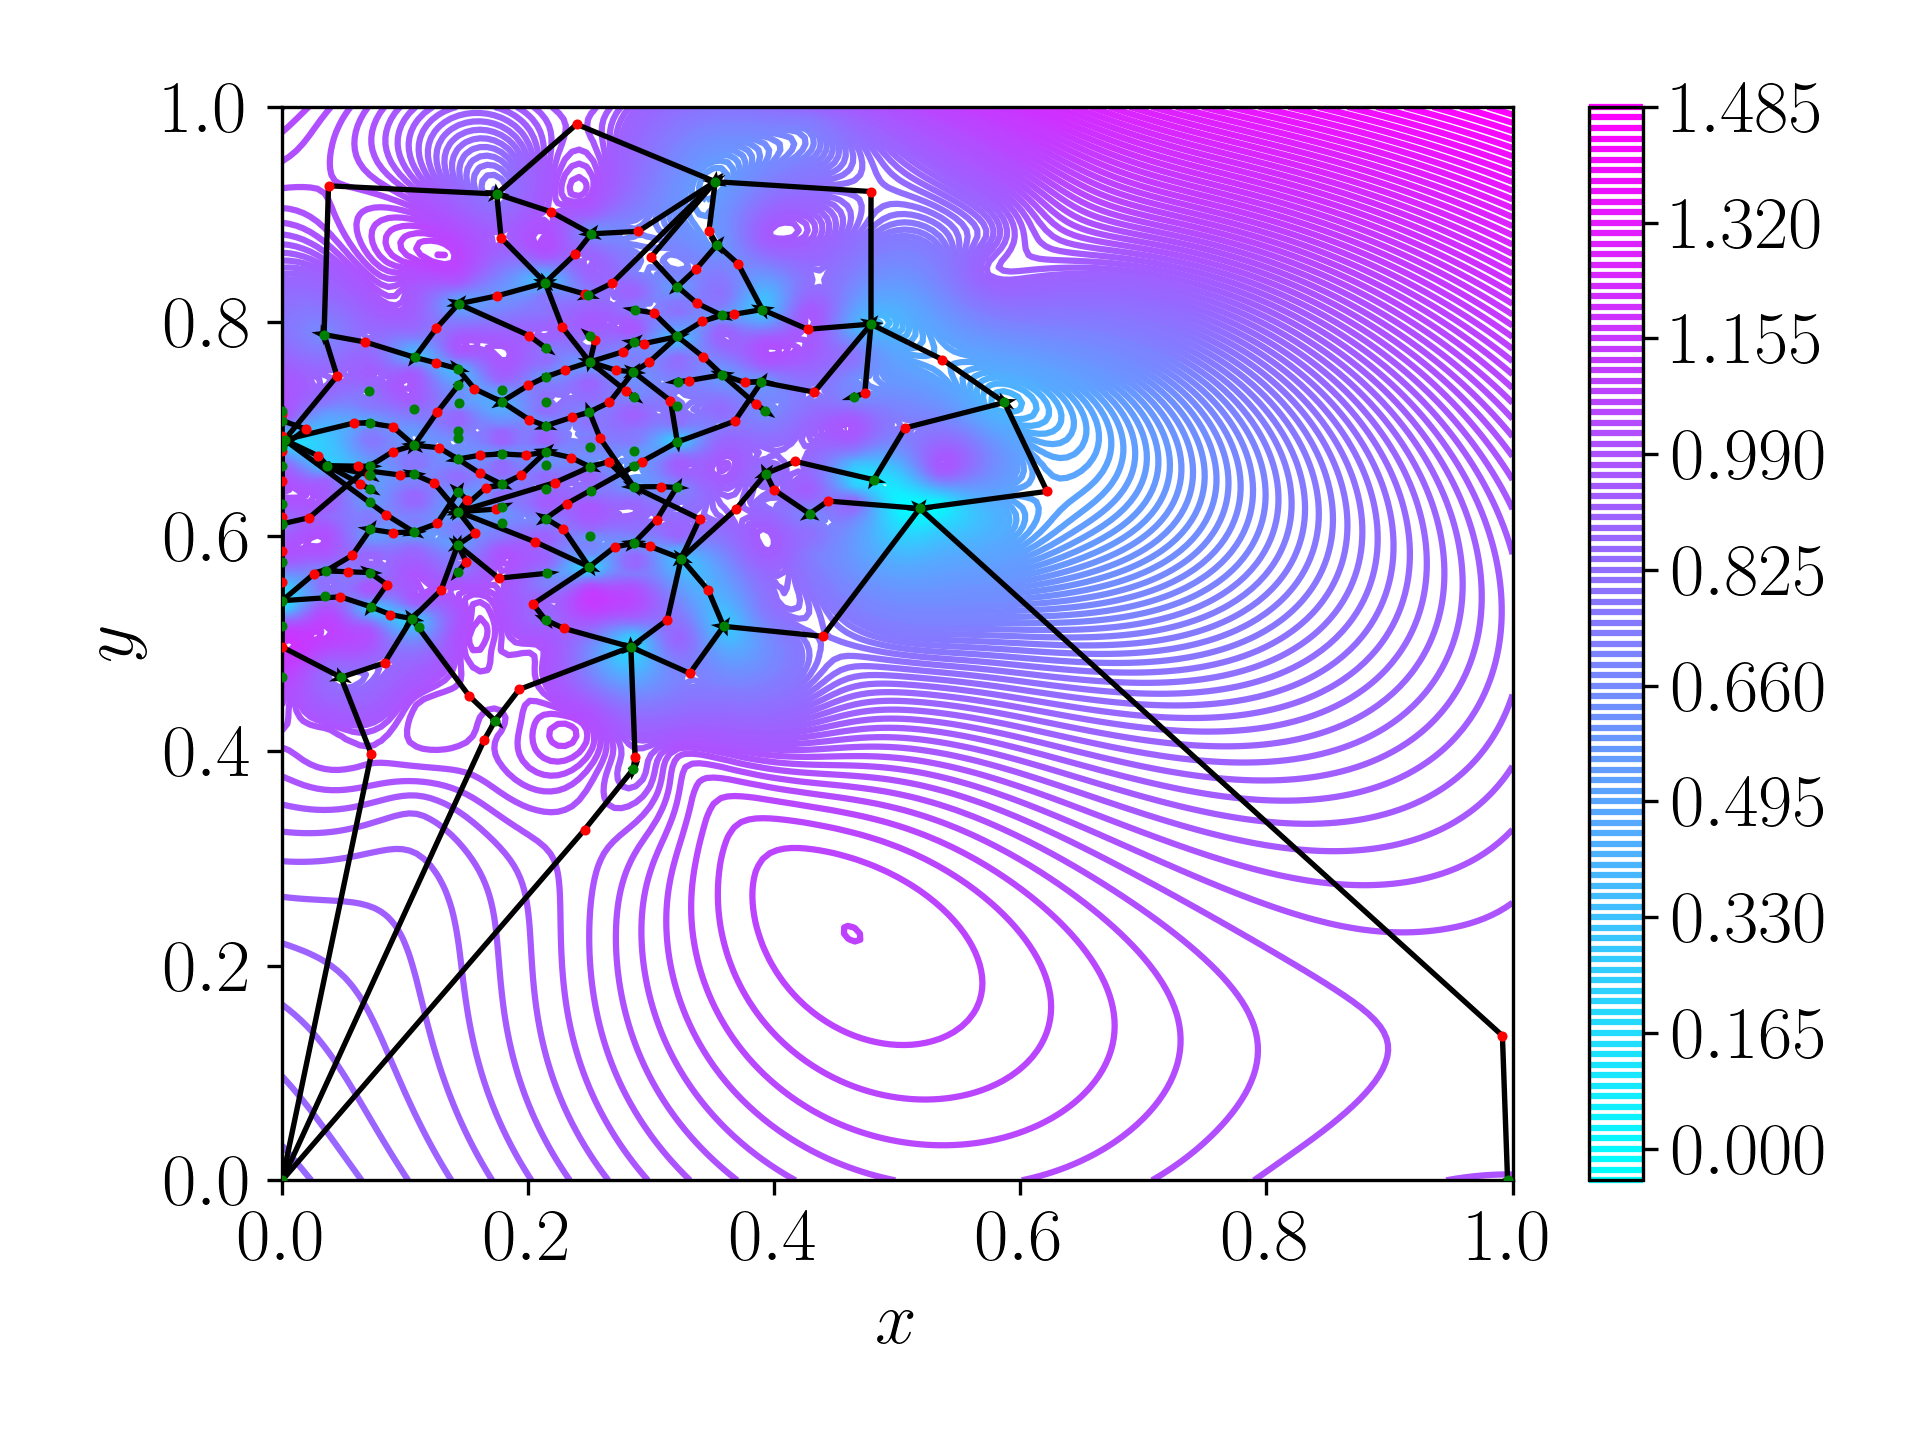

In [85]:
# Create the interpolating function
interpolation.refit_model()
# Plot the interpolation
from topsearch.plotting.stationary_points import plot_stationary_points
from IPython.display import Image
plot_stationary_points(potential=interpolation,
                       ktn=ktn,
                       bounds=coords.bounds,
                       contour_levels=125,
                       fineness=175)
Image(filename='StationaryPoints.png')

We perform basin-hopping to locate all local minima of the interpolated function fitted to the dataset. To ensure good coverage of all regions of space containing data we start many short basin-hopping runs, one from each data point in turn.

In [83]:
# Loop over all training data
for d_p in model_data.training:
    # Set the coordinates to that of the training data point
    coords.position = d_p
    # Run the basin-hoppping
    explorer.get_minima(coords=coords, # the coordinates object
                        n_steps=5, # the number of basin-hopping steps
                        conv_crit=1e-4, # the convergence criterion for local minimisation
                        temperature=100.0, # sampling parameter that controls acceptance of new minima
                        test_valid=True) # check the eigenspectrum to guarantee local minimum

We can again visualise the interpolated function, this time with the local minima overlaid as green circles.

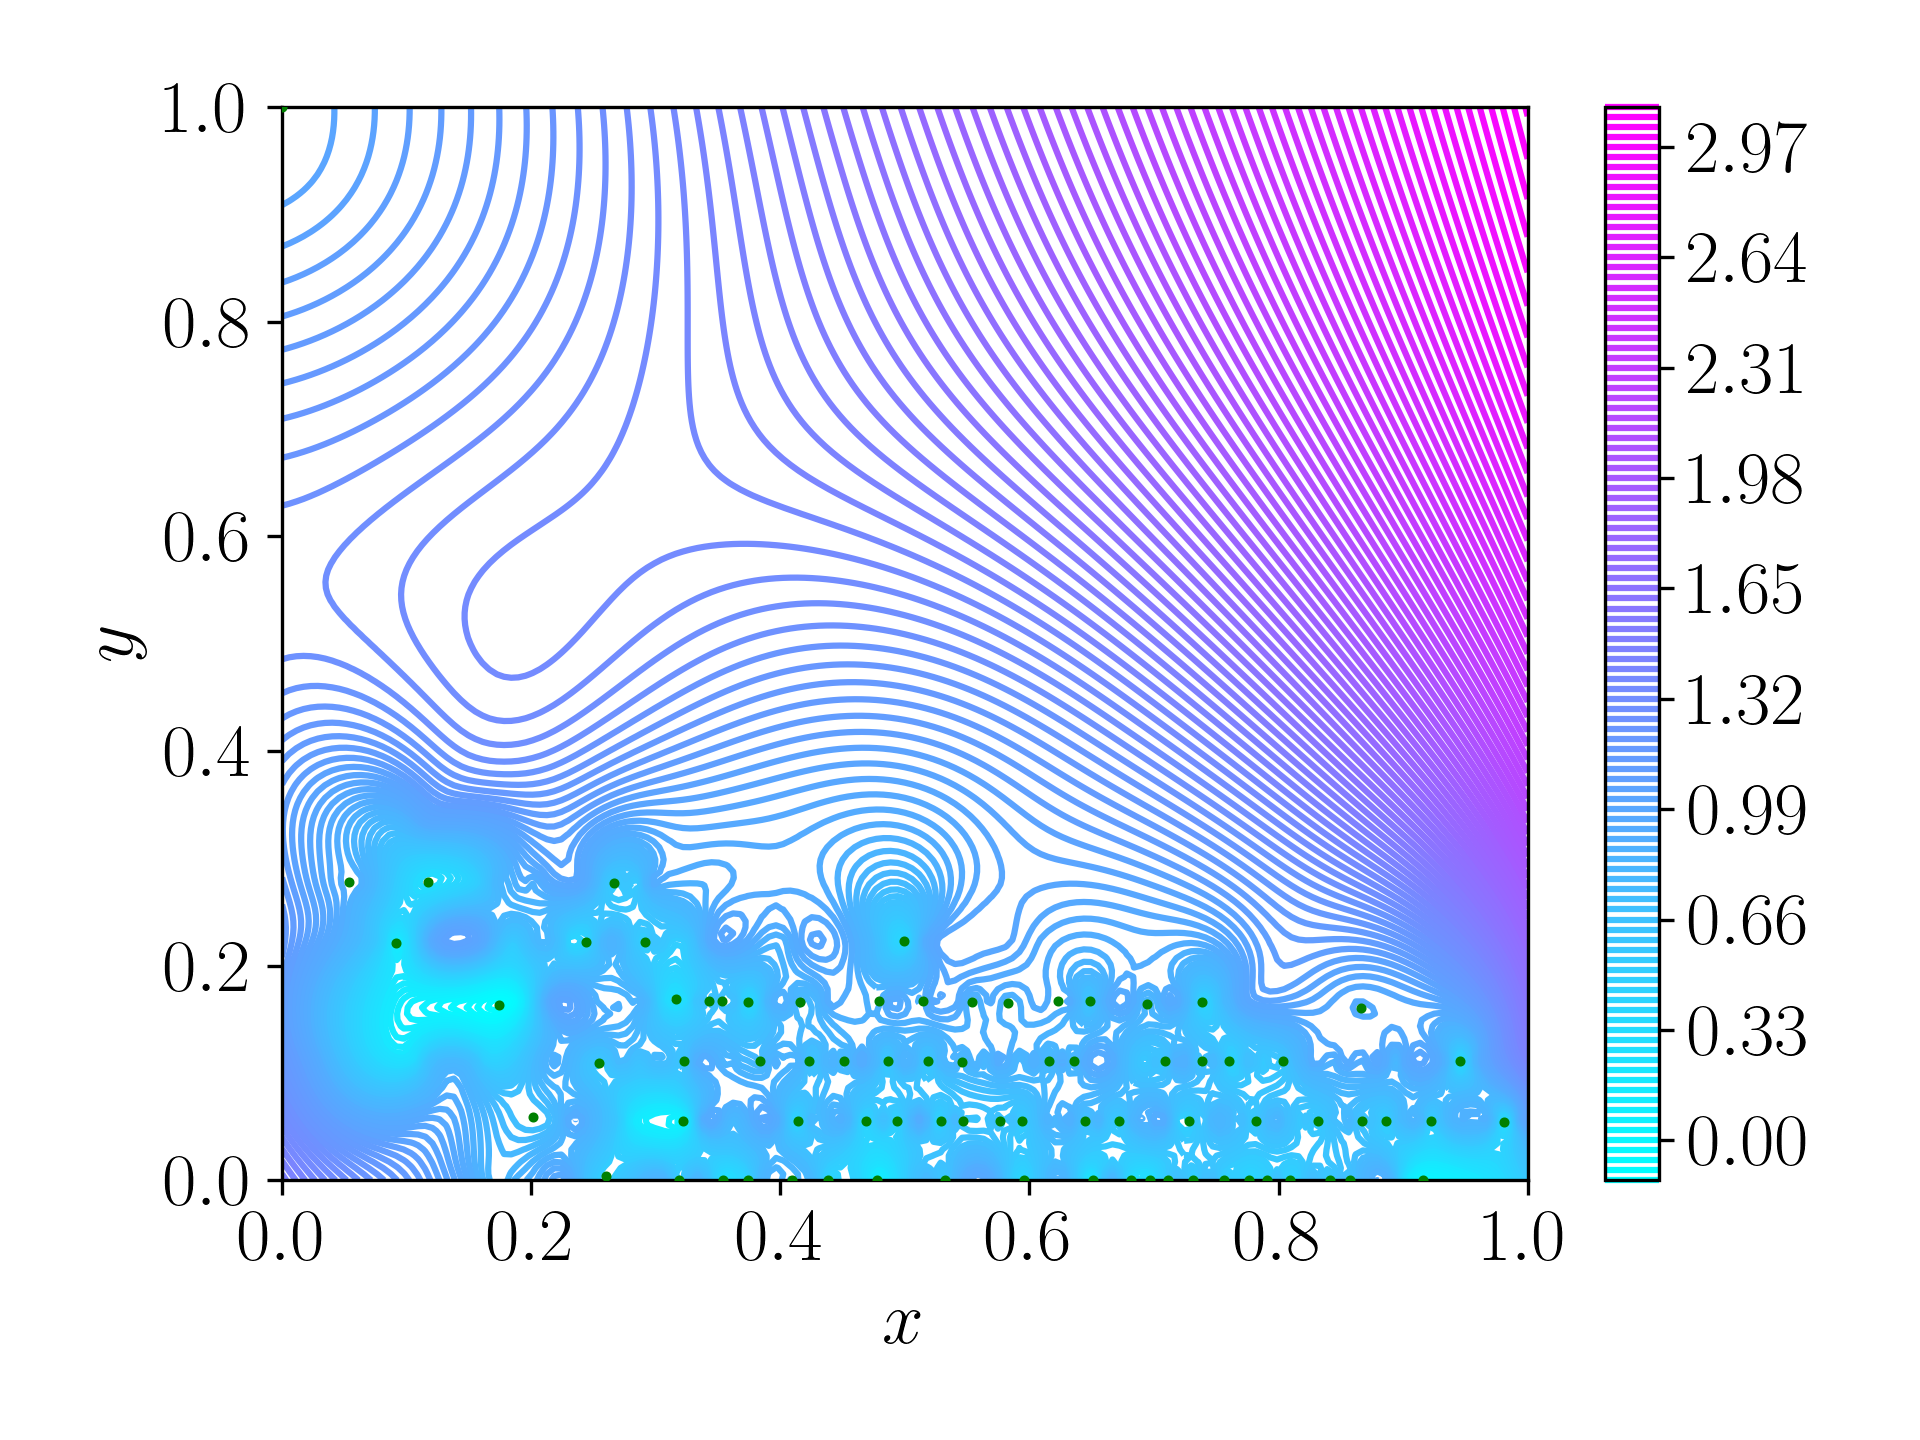

In [73]:
from topsearch.plotting.stationary_points import plot_stationary_points
from IPython.display import Image
plot_stationary_points(potential=interpolation,
                       ktn=ktn,
                       bounds=coords.bounds,
                       contour_levels=125,
                       fineness=175)
Image(filename='StationaryPoints.png')

We remove any local minima that are outside the convex hull formed by the complete dataset. Interpolation will likely be poor outside this region as there is limited data on which to base the function. Therefore, we choose to exclude these regions from our analysis.

In [74]:
import numpy as np
outside_hull = []
for j in range(ktn.n_minima):
    point = ktn.get_minimum_coords(j)
    if not model_data.point_in_hull(point):
        outside_hull.append(j)
ktn.remove_minima(np.asarray(outside_hull))

We compute the transition states between the remaining set of minima. These transition states are the maxima on the minimum energy paths between minima and describe the intermediate structure of the surface between minima. In two dimensions each transition state can be seen as maximal in one direction and minimal in the orthogonal direction. With transition states as well this network of stationary points can encode the topography of the surface. We attempt transition state searches between each minimum and its 12 nearest neighbours in the surface.

In [75]:
explorer.get_transition_states(method='ClosestEnumeration', # the scheme for selecting pairs of minima to connect
                               cycles=12, # the number of neighbours
                               remove_bounds_minima=False) # whether to ignore minima at bounds of the space

We have now located the transition states between all minima and we visualise the complete network overlaid on the interpolating function. Transition states are shown in red and solid black lines indicates connections between each transition state and its local minima.

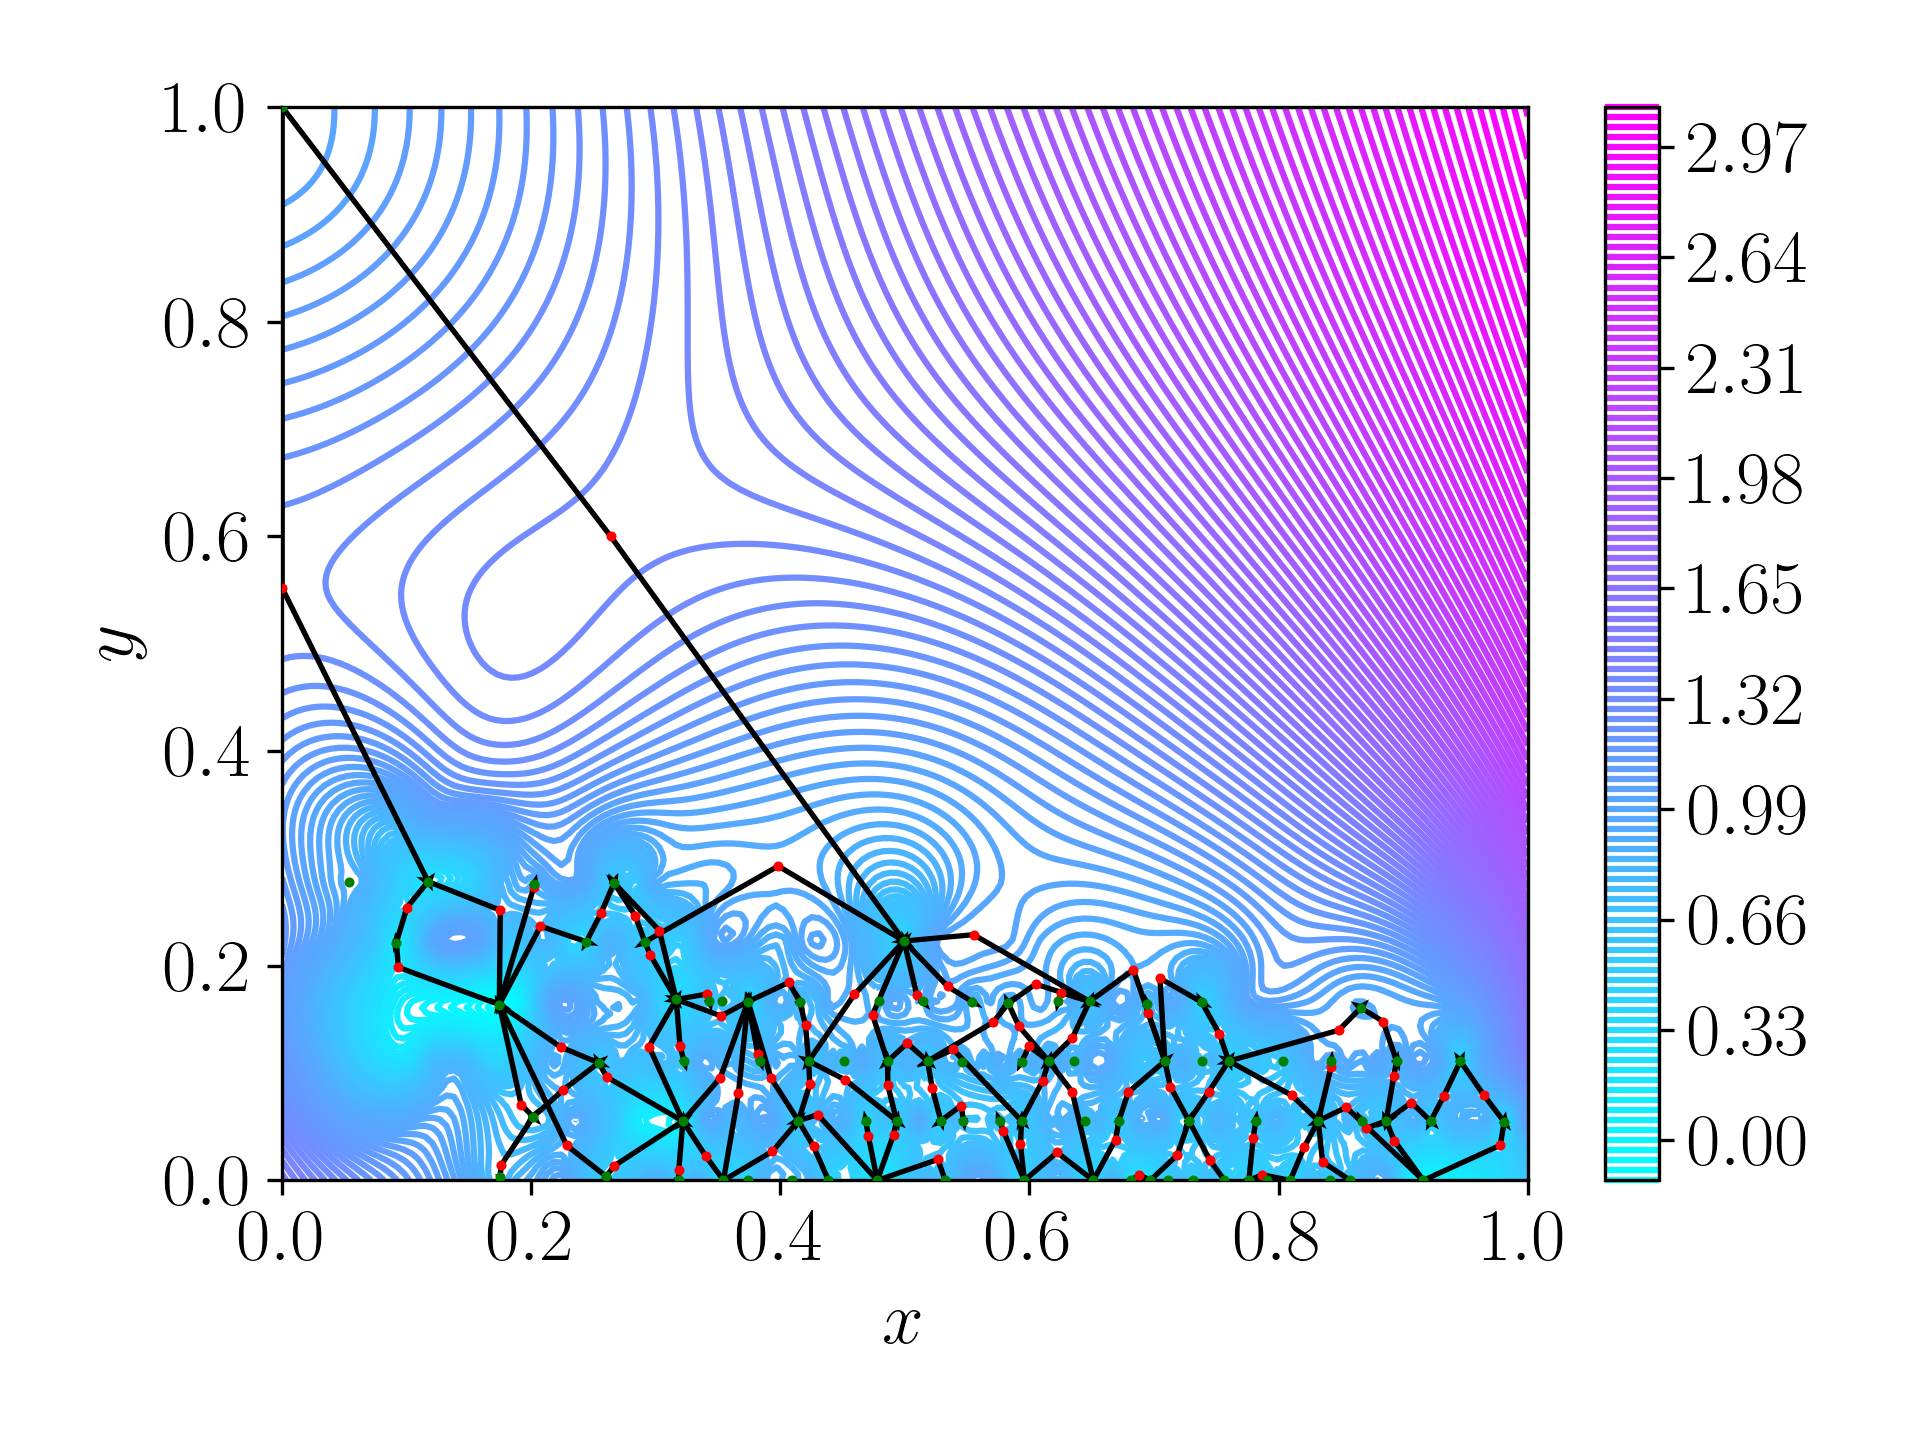

In [76]:
plot_stationary_points(potential=interpolation,
                       ktn=ktn,
                       bounds=coords.bounds,
                       contour_levels=125,
                       fineness=175)
Image(filename='StationaryPoints.png')

From the network of minima and transition states we can easily compute the frustration metric by

In [87]:
from topsearch.analysis.roughness import roughness_metric
frustration = roughness_metric(ktn=ktn,
                               lengthscale=0.8)
print(f"Frustration for features [0, 1]: {frustration}")

Frustration for features [0, 1]: 0.6774304511790922


## Total frustration

We have computed the frustration associated with a particular pair of features. Now we repeat the process over all pairs of features to get the total frustration. Having shown the process for a single feature pair we do this without pausing at each step.

In [78]:


model_data.read_data(training_file='training.txt',
                     response_file='response.txt')
pairs = []
for i in range(0, model_data.n_dims-1):
    for j in range(i+1, model_data.n_dims):
        pairs.append([i, j])


frustration_values = []

for i in pairs:

    model_data.read_data(training_file='training.txt',
                         response_file='response.txt')
    model_data.feature_subset(i)
    model_data.remove_duplicates()
    model_data.normalise_training()
    model_data.normalise_response()
    model_data.convex_hull()

    interpolation.refit_model()

    for d_p in model_data.training:
        coords.position = d_p
        explorer.get_minima(coords=coords,
                            n_steps=5,
                            conv_crit=1e-4,
                            temperature=100.0,
                            test_valid=True)
    
    outside_hull = []
    for j in range(ktn.n_minima):
        point = ktn.get_minimum_coords(j)
        if not model_data.point_in_hull(point):
            outside_hull.append(j)
    ktn.remove_minima(np.asarray(outside_hull))

    explorer.get_transition_states(method='ClosestEnumeration',
                                   cycles=12,
                                   remove_bounds_minima=False)
    
    plot_stationary_points(potential=interpolation,
                           ktn=ktn,
                           bounds=coords.bounds,
                           contour_levels=125,
                           fineness=175,
                           label='%i_%i' %(i[0], i[1]))
    
    frustration = roughness_metric(ktn=ktn,
                                   lengthscale=0.8)
    frustration_values.append(frustration)
    print(f"Frustration for features {i}: {frustration}")

Pairs:  [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
Frustration for features [0, 1]: 0.7675524196737578
Frustration for features [0, 2]: 0.9023536656209665
Frustration for features [0, 3]: 1.0787059997568798


/Users/lukedicks/topography-searcher/src/topsearch/transition_states/hybrid_eigenvector_following.py:457: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)
/Users/lukedicks/topography-searcher/src/topsearch/transition_states/hybrid_eigenvector_following.py:457: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)


Frustration for features [1, 2]: 1.1660410321606476
Frustration for features [1, 3]: 0.6151687102594422
Frustration for features [2, 3]: 0.677430451179093


We have plotted the topographical mappings for each feature pair and we can visualise each of these in turn. Finally we print the overall frustration value for the dataset computed as an average over all the feature pairs.

Frustration:  0.8678753797751311


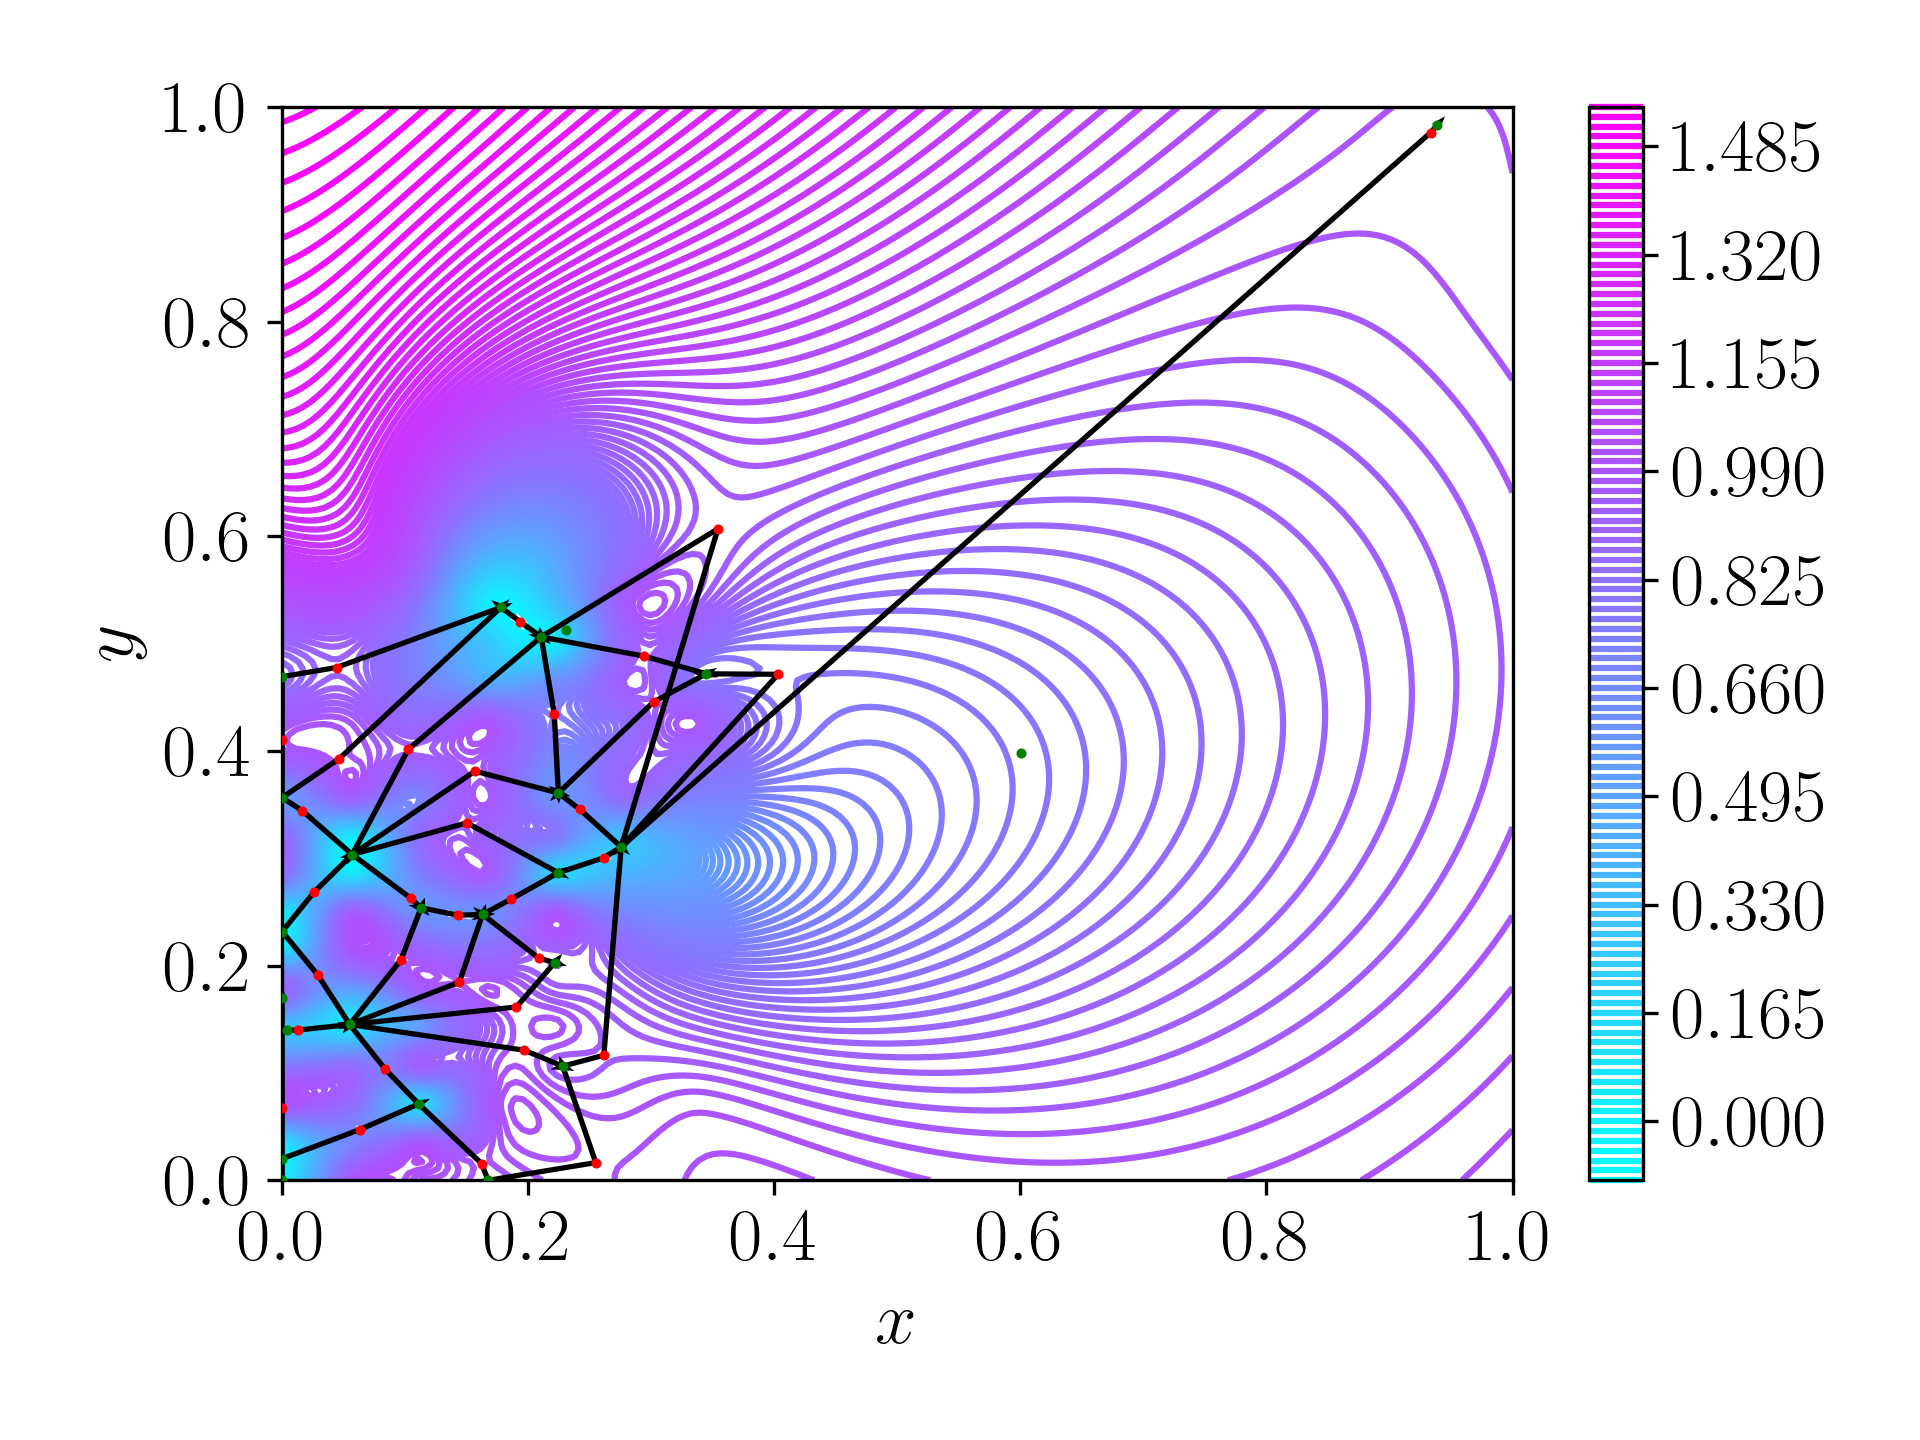

In [82]:
from IPython.display import Image
print("Frustration: ", np.average(np.asarray(frustration_values)))
#Image(filename='StationaryPoints0_2.png')
Image(filename='StationaryPoints1_2.png')
#Image(filename='StationaryPoints0_3.png')
#Image(filename='StationaryPoints1_3.png')
#Image(filename='StationaryPoints2_3.png')